In [ ]:
from tqdm import tqdm
import time

from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/pixelcnn

/content/gdrive/MyDrive/pixelcnn


## Prepare dataset


In [ ]:
num_classes = 10
n_dims = 28
n_residual_blocks = 10
batch_size = 1500
n_epoch = 30

n_block_x_dim = 4
n_block_y_dim = 4


n_block_dim = n_block_x_dim * n_block_y_dim
n_hidden = 10
z_dim = n_block_dim

n_residual_blocks = 3
batch_size = 200
n_epoch = 2000

In [ ]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
def to_one_hot(labels, n_x_blocks, n_y_blocks, n=10):
  one_hot = np.zeros((len(labels), n_x_blocks, n_y_blocks, n))
  for i in range(1, len(labels)):
    one_hot[i, :, :, labels[i]] = 1.
  return one_hot.astype(np.float32)

In [ ]:
# data preprocessing parameters
n_x_dim = n_dims
n_y_dim = n_dims

n_blocks = int((n_x_dim * n_y_dim) / (n_block_x_dim * n_block_y_dim))
n_x_blocks = int(n_x_dim / n_block_x_dim)
n_y_blocks = int(n_y_dim / n_block_y_dim)

input_shape = (n_x_blocks, n_y_blocks, n_block_x_dim * n_block_y_dim)

y_train = to_one_hot(y_train, n_x_blocks, n_y_blocks, 10)
y_test = to_one_hot(y_test, n_x_blocks, n_y_blocks, 10)

In [ ]:
def create_x_data_rnn(data_x, n_dims, n_x_blocks, n_y_blocks, n_block_dim):
  data_x = data_x.reshape((data_x.shape[0], n_dims, n_dims))
  x_rnn = np.zeros((data_x.shape[0], n_x_blocks, n_y_blocks, n_block_dim),
                   dtype=np.float32)
  for i in range(data_x.shape[0]):
      for xi in range(n_x_blocks):
          for yi in range(n_y_blocks):
              x_start = xi * n_block_x_dim
              x_end = (xi + 1) * n_block_x_dim
              y_start = yi * n_block_y_dim
              y_end = (yi + 1) * n_block_y_dim
              x_rnn[i, xi, yi, :] = data_x[
                  i, x_start: x_end, y_start: y_end].flatten()
  return x_rnn

In [ ]:
# prep dataset
x_train_rnn = create_x_data_rnn(
    x_train, n_dims, n_x_blocks, n_y_blocks, n_block_dim)
x_test_rnn = create_x_data_rnn(
    x_test, n_dims, n_x_blocks, n_y_blocks, n_block_dim)

In [ ]:
n_hidden = x_train_rnn.shape[-1]
z_dim = x_train_rnn.shape[-1]

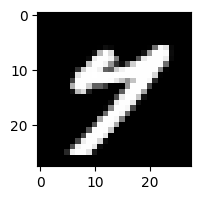

In [ ]:
figure = np.zeros((n_x_dim, n_x_dim))
for i in range(n_x_blocks):
    for j in range(n_y_blocks):
        digit = x_train_rnn[1001,i, j,:].reshape([n_block_x_dim, n_block_y_dim])
        figure[i * n_block_x_dim: (i + 1) * n_block_x_dim,
               j * n_block_y_dim: (j + 1) * n_block_y_dim] = digit

plt.figure(figsize=(2, 2))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Base


In [ ]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="linear"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters,
            kernel_size=3,
            activation="linear",
            padding="same",
        )
        self.activation = layers.LeakyReLU(0.1)
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="linear"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.activation(x)
        x = self.pixel_conv(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        return keras.layers.add([inputs, x])

In [ ]:
def makeScaleMatrix(num_gen, num_orig):
        # first 'N' entries have '1/N', next 'M' entries have '-1/M'
        s1 =  tf.constant(1.0 / num_gen, shape = [num_gen, 1])
        s2 = - tf.constant(1.0 / num_orig, shape = [num_orig, 1])
        return tf.concat([s1, s2], axis=0)


def _mmd_loss1(x, gen_x, sigma = [2, 5, 10, 20, 40, 80]):
        # concatenation of the generated images and images from the dataset
        # first 'N' rows are the generated ones, next 'M' are from the data
        X = tf.concat([gen_x, x], axis=0)

        # dot product between all combinations of rows in 'X'
        XX = tf.matmul(X, tf.transpose(X))

        # dot product of rows with themselves
        X2 = tf.reduce_sum(X * X, 1, keepdims=True)

        # exponent entries of the RBF kernel (without the sigma) for each
        # combination of the rows in 'X'
        # -0.5 * (x^Tx - 2*x^Ty + y^Ty)
        exponent = XX - 0.5 * X2 - 0.5 * tf.transpose(X2)

        # scaling constants for each of the rows in 'X'
        s = makeScaleMatrix(x.shape[0], x.shape[0])

        # scaling factors of each of the kernel values, corresponding to the
        # exponent values
        S = tf.matmul(s, tf.transpose(s))

        loss = 0

        # for each bandwidth parameter, compute the MMD value and add them all
        for i in range(len(sigma)):
            # kernel values for each combination of the rows in 'X'
            kernel_val = tf.exp(1.0 / sigma[i] * exponent)
            loss += tf.reduce_sum(S * kernel_val)
        return tf.sqrt(loss)


def _mmd_loss_block(x, gen_x, sigma = [2, 5, 10, 20, 40, 80]):
        # concatenation of the generated images and images from the dataset
        # first 'N' rows are the generated ones, next 'M' are from the data
        X = tf.transpose(tf.concat([gen_x, x], axis=0), perm = [1, 2, 0, 3])

        # dot product between all combinations of rows in 'X'
        XX = tf.matmul(X, tf.transpose(X, perm = [0, 1, 3, 2]))

        # dot product of rows with themselves
        X2 = tf.reduce_sum(X * X, -1, keepdims=True)

        # exponent entries of the RBF kernel (without the sigma) for each
        # combination of the rows in 'X'
        # -0.5 * (x^Tx - 2*x^Ty + y^Ty)
        exponent = XX - 0.5 * X2 - 0.5 * tf.transpose(X2, perm = [0, 1, 3, 2])

        # scaling constants for each of the rows in 'X'
        s = makeScaleMatrix(x.shape[0], x.shape[0])

        # scaling factors of each of the kernel values, corresponding to the
        # exponent values
        S = tf.matmul(s, tf.transpose(s))

        loss = 0
        # for each bandwidth parameter, compute the MMD value and add them all
        for i in range(len(sigma)):
            # kernel values for each combination of the rows in 'X'
            kernel_val = tf.exp(1.0 / sigma[i] * exponent)
            loss += tf.reduce_sum(S * kernel_val)
        return tf.sqrt(loss)


# convert mmd_loss1 into block version
# current norm might be better with RBF kernels as in mmd_loss
def _mmd_loss2(x, y):
    xx = tf.matmul(x, tf.transpose(x))
    yy = tf.matmul(y, tf.transpose(y))
    xy = tf.matmul(x, tf.transpose(y))
    mmd = tf.reduce_mean(xx) - 2*tf.reduce_mean(xy) + tf.reduce_mean(yy)
    return tf.sqrt(mmd)


def _energy_loss(y_pred1, y_pred2, y_true):
    norm1 = tf.norm(y_pred1 - y_pred2, axis=1)
    norm2 = tf.norm(y_pred1 - y_true, axis=1)
    energy_score = 0.5*norm1**0.5 - norm2**0.5
    return -tf.reduce_mean(energy_score, axis=0)


def _rbf_kernel(x, y, scale):
  return  tf.exp(-(x - y)**2 / (scale))


def _energy_loss_block(y_pred1, y_pred2, y_true, power):
    norm1 = tf.norm(y_pred1 - y_pred2, axis=3)
    norm2 = tf.norm(y_pred1 - y_true, axis=3)
    norm1 = tf.where(tf.equal(norm1, 0), tf.zeros_like(norm1), norm1)
    norm2 = tf.where(tf.equal(norm2, 0), tf.zeros_like(norm2), norm2)
    energy_score = 0.5 * norm1**power - norm2**power
    energy_score = tf.reduce_sum(energy_score, axis=(1, 2))
    return - tf.reduce_mean(energy_score, axis=0)


def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])),
                      tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])),
                      tf.stack([x_size, 1, 1]))
    return tf.exp(- tf.reduce_mean(
        tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)


def _energy_loss_block_kernel(y_pred1, y_pred2, y_true, sigma = [2, 5, 10, 20, 40, 80]):
    loss = 0
    for scale in sigma:
      xx = _rbf_kernel(y_pred1, y_pred2, scale)
      xy = _rbf_kernel(y_pred1, y_true, scale)
      energy_score = 0.5 * tf.reduce_sum(xx, axis = 3) - tf.reduce_sum(xy, axis = 3)
      energy_score = tf.reduce_sum(energy_score, axis = [1, 2])
      loss = loss - tf.reduce_mean(energy_score, axis=0)
    return loss


def quantile_loss(y_pred, y_true, alpha):
  # note: all inputs have shape (n_batch, n_dims)
  loss_vector = tf.maximum(
      alpha * (y_true - y_pred),
      (alpha - 1) * (y_true - y_pred))
  return tf.reduce_mean(loss_vector)

In [ ]:
import keras
from keras.layers import BatchNormalization
import random
# define model
class PixelCNN_MMD(tf.keras.Model):
    def __init__(self, **kwargs):
        super(PixelCNN_MMD, self).__init__(**kwargs)
        # create model layers
        self.x_decoder = PixelConvLayer(
            mask_type="A", filters=64, kernel_size=3,
            activation="linear", padding="same")
        self.z_decoder = PixelConvLayer(
            mask_type="B", filters=64, kernel_size=3,
            activation="linear", padding="same")
        self.residual_blocks = []
        for _ in range(n_residual_blocks):
            self.residual_blocks.append(ResidualBlock(filters=128))

        self.lrelu = LeakyReLU(0.1)

        self.pixel_convs = []
        self.pixel_convs.append(PixelConvLayer(
              mask_type="B",
              filters=128,
              kernel_size=1,
              strides=1,
              activation="linear",
              padding="valid",
          ))
        self.pixel_convs.append(PixelConvLayer(
              mask_type="B",
              filters=n_block_x_dim*n_block_y_dim,
              kernel_size=1,
              strides=1,
              activation="sigmoid",
              padding="valid",
        ))
        self.batchnorms = []
        for i in range(5):
          self.batchnorms.append(BatchNormalization(axis = 3))
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.power = 2

    def call(self, input):
        inputx = input[0]
        inputz = input[1]
        x_decoded = self.x_decoder(inputx)
        x_decoded = self.lrelu(x_decoded)
        z_decoded = self.z_decoder(inputz)
        z_decoded = self.lrelu(z_decoded)
        z_decoded = self.batchnorms[0](z_decoded)
        z_decoded = tf.concat((x_decoded, z_decoded), -1)
        for i in range(n_residual_blocks):
          z_decoded = self.residual_blocks[i](z_decoded)
          z_decoded = self.lrelu(z_decoded)
          z_decoded = self.batchnorms[i+1](z_decoded)
        z_decoded = self.pixel_convs[0](z_decoded)
        z_decoded = self.lrelu(z_decoded)
        z_decoded = self.batchnorms[4](z_decoded)
        x_decoded = self.pixel_convs[1](z_decoded)
        return x_decoded

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = 0
            y_target = data[0]
            labels = data[1]
            shape = (y_target.shape[0], n_x_blocks, n_y_blocks,
                     n_block_x_dim*n_block_y_dim)
            z1 = tf.concat((tf.random.normal(shape=shape), labels), -1)
            z2 = tf.concat((tf.random.normal(shape=shape), labels), -1)
            y_pred1 = self((y_target, z1), training=True)
            y_pred2 = self((y_target, z2), training=True)
            loss = _energy_loss_block(y_pred1, y_pred2, y_target, 0.5)

        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
pixel_cnn = PixelCNN_MMD()
pixel_cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [ ]:
pixel_cnn.fit(x_train_rnn, y_train, epochs=1, batch_size=batch_size)

300/300 [==============================] - 18s 27ms/step - loss: 29.0862


In [ ]:
pixel_cnn.summary()

Model: "pixel_cnn_mmd_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_conv_layer_7 (PixelCo  multiple                 9280      
 nvLayer)                                                        
                                                                 
 pixel_conv_layer_8 (PixelCo  multiple                 15040     
 nvLayer)                                                        
                                                                 
 residual_block_3 (ResidualB  multiple                 180608    
 lock)                                                           
                                                                 
 residual_block_4 (ResidualB  multiple                 180608    
 lock)                                                           
                                                                 
 residual_block_5 (ResidualB  multiple             

In [ ]:
pixel_cnn.save('./pixelcnn.mdl')

## Demonstration

The PixelCNN cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/pixel-cnn-mnist) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/pixelcnn-mnist-image-generation).

In [ ]:
temp = keras.models.load_model('./pixelcnn.mdl')
pixel_cnn = PixelCNN_MMD()
pixel_cnn.set_weights(temp.get_weights())

In [ ]:
# Create an empty array of pixels.
batch = 297 * 20
given = 0
pixels = np.zeros(shape=(batch,) + input_shape)
batch, rows, cols, channels = pixels.shape
alpha = tf.random.normal(shape=pixels.shape) # (n_batch, n_dims)

conditional = np.zeros((pixels.shape[0], pixels.shape[1], pixels.shape[2], 10))
for i in range(0, conditional.shape[0]):
  conditional[i, :, :, random.randint(0, 9)] = 1.
conditional.astype(np.float32)
alpha = tf.concat((alpha, conditional), axis = -1)
print(alpha.shape)

start_time = time.time()
# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(given, rows)):
    for col in range(cols):
          # Feed the whole array and retrieving the pixel value probabilities for the next
          # pixel.
          value = pixel_cnn.predict((pixels, alpha))[:, row, col, :]
          # Use the probabilities to pick pixel values and append the values to the image
          # frame.
          pixels[:, row, col, :] = value
print(time.time()-start_time)

pixels2 = np.zeros(shape=(batch,n_dims, n_dims))
for b in range(batch):
  for i in range(n_x_blocks):
      for j in range(n_y_blocks):
          digit = pixels[b,i, j,:].reshape([n_block_x_dim, n_block_y_dim])
          pixels2[b, i * n_block_x_dim: (i + 1) * n_block_x_dim,
                          j * n_block_y_dim: (j + 1) * n_block_y_dim] = digit

(5940, 7, 7, 26)


  0%|          | 0/7 [00:00<?, ?it/s]

186/186 [==============================] - 1s 3ms/step


 14%|█▍        | 1/7 [00:07<00:42,  7.06s/it]

186/186 [==============================] - 1s 4ms/step


 29%|██▊       | 2/7 [00:14<00:35,  7.16s/it]

186/186 [==============================] - 1s 3ms/step


 43%|████▎     | 3/7 [00:21<00:27,  6.98s/it]

186/186 [==============================] - 1s 3ms/step


 57%|█████▋    | 4/7 [00:25<00:17,  6.00s/it]

186/186 [==============================] - 1s 3ms/step


 71%|███████▏  | 5/7 [00:33<00:13,  6.79s/it]

186/186 [==============================] - 1s 3ms/step


 86%|████████▌ | 6/7 [00:38<00:06,  6.08s/it]

186/186 [==============================] - 1s 4ms/step


100%|██████████| 7/7 [00:47<00:00,  6.73s/it]


47.14532995223999


In [ ]:
batch = 100
testing_x = np.repeat(x_test_rnn[0: 1], 100, 0)
testing_y = np.repeat(y_test[0: 1], 100, 0)
# testing_x = x_test_rnn[0:batch]
# testing_y = y_test[0:batch]
alpha = tf.random.normal(shape=testing_x.shape)
alpha = tf.concat((alpha, testing_y), axis = -1)
pixels = pixel_cnn.predict((testing_x, alpha))
pixels2 = np.zeros(shape=(batch,n_dims, n_dims))
for b in range(batch):
  for i in range(n_x_blocks):
      for j in range(n_y_blocks):
          digit = pixels[b,i, j,:].reshape([n_block_x_dim, n_block_y_dim])
          pixels2[b, i * n_block_x_dim: (i + 1) * n_block_x_dim,
                          j * n_block_y_dim: (j + 1) * n_block_y_dim] = digit

4/4 [==============================] - 0s 77ms/step


In [ ]:
# display a 2D manifold of the digits
n = 10 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        digit = pixels2[i*n + j].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(4, 4))
plt.imshow(figure, cmap='Greys_r')
plt.show()
#keep training and checking, can probably still keep training a li
#plot samples incrementally - see how the image quality improves
#get much better looking samples by doing some dimensionality reduction first? (autoencoder first, or PCA)


ValueError: ignored

In [ ]:
np.save("pixelcnn-digits-1-revised.npy", pixels2.reshape(10000, 64))